# Molecular Tastants
Bogna Kilanowska 148252
https://www.kaggle.com/competitions/molecular-tastants

## Project setup
- load data
- load libs

In [40]:
import numpy as np 

np.random.seed(973)

In [41]:
import pandas as pd

df = pd.read_csv('data/train.csv')
df.head()

,molecule_id,smiles,taste
0,train_0,C=C1CC23CCC4C(C)(C(=O)O)CCCC4(C)C2CCC1(OC1OC(C...,6
1,train_1,Nc1ccccc1NS(=O)(=O)[O-].[Na+],3
2,train_2,O=C1NS(=O)(=O)c2cc(O)ccc21,6
3,train_3,OCC1OC(Oc2ccc3ccccc3c2)C(O)C(O)C1O,0
4,train_4,CCC1(C2=CCCCCC2)C(=O)NC(=O)NC1=O,0


## Preliminary data analysis

In [42]:
df.shape

(1809, 3)

In [43]:
print("Na count:")
print(df.isna().sum())
print("NULL count:")
print(df.isnull().sum())

Na count:
molecule_id    0
smiles         0
taste          0
dtype: int64
NULL count:
molecule_id    0
smiles         0
taste          0
dtype: int64


taste
0    731
6    589
3    149
7    125
2     69
8     63
1     50
5     25
4      8
Name: count, dtype: int64


array([[<Axes: title={'center': 'taste'}>]], dtype=object)

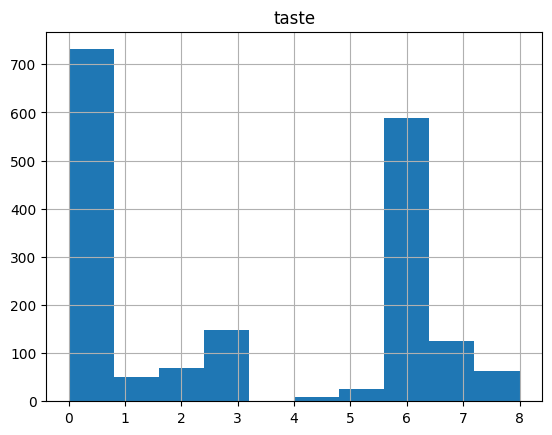

In [44]:
print(df.taste.value_counts())
df.hist(column='taste')

## Data pre-processing

### Data encoding

In [45]:
from rdkit.Chem import MACCSkeys
from rdkit import Chem

def get_maccs_fps(dataframe):
    maccs = [MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x)) for x in dataframe['smiles']]
    maccs_lists = [list(l) for l in maccs]
    maccs_name = [f'MACCS_{i}' for i in range(167)]

    return pd.DataFrame(maccs_lists, index=dataframe.index, columns=maccs_name)

### Data balancing

In [94]:
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from collections import Counter

def balance_classes(X, y, info = True, sampling_strategy = 'auto', random_state = 973, k_neighbors = 5):
    sme = SMOTE(
        sampling_strategy=sampling_strategy,
        random_state = random_state,
        k_neighbors=k_neighbors)

    if info: print(f'Classes distribution before sampling : {sorted(Counter(y).items())}')
    X_resampled, y_resampled = sme.fit_resample(X, y)
    if info: print(f'Classes distribution after sampling: {sorted(Counter(y_resampled).items())}')

    return X_resampled, y_resampled

### Feature engineering

In [73]:
from sklearn.feature_selection import VarianceThreshold

def select_features(data, threshold = 0.05, info = True):
    
    if info: print(data.shape)
    selector = VarianceThreshold(threshold=threshold)
    selector.fit_transform(data)
    if info: print(data[data.columns[selector.get_support(indices=True)]].shape)

    return data[data.columns[selector.get_support(indices=True)]]

## Train test split

In [48]:
from sklearn.model_selection import train_test_split

def train_test_split_data(X = df.smiles, y = df.taste):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    print(f'Classes distribution train: {sorted(Counter(y_train).items())}')
    print(f'Classes distribution test: {sorted(Counter(y_test).items())}')

    return X_train, X_test, y_train, y_test 

In [49]:
X = get_maccs_fps(df)
y = df.taste

X_train, X_test, y_train, y_test = train_test_split_data(X, y)

Classes distribution train: [(0, 596), (1, 38), (2, 52), (3, 115), (4, 7), (5, 19), (6, 471), (7, 100), (8, 49)]
Classes distribution test: [(0, 135), (1, 12), (2, 17), (3, 34), (4, 1), (5, 6), (6, 118), (7, 25), (8, 14)]


## Choosing classifier

## Model

In [50]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def train_model(X_train, y_train):

    clf = RandomForestClassifier(random_state=0)
    clf.fit(X_train, y_train)
    
    return clf

def make_prediction(clf, X_test):
    y_pred = clf.predict(X_test)

    return y_pred

def evaluate_model(y_test, y_pred, print_acc = True, show_cm = True, cm_labels = [0,1,2,3,4,5,6,7,8]):
    acc = balanced_accuracy_score(y_test, y_pred)

    if print_acc:
        print(f"Balanced accuracy: {acc:.2%}")

    if show_cm:
        cm = confusion_matrix(y_test, y_pred, labels = cm_labels)
        cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8])
        cm_display.plot()
        plt.show()

    return acc



## Evaluation

### Case 01: model

Balanced accuracy: 42.57%


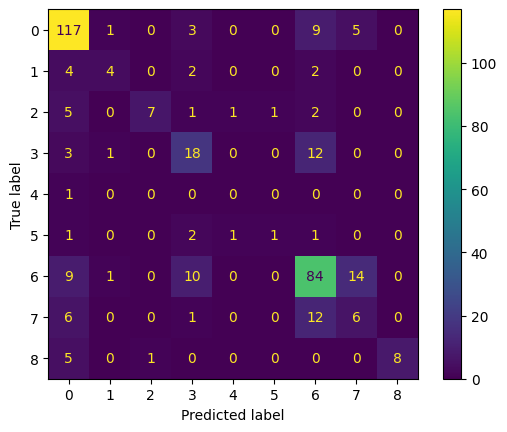

In [ ]:
clf = train_model(X_train, y_train)
y_pred = make_prediction(clf, X_test)
acc = evaluate_model(y_test, y_pred)

In [67]:
n_iterations = 10
acc_scores = []

for i in range(n_iterations):
    clf = train_model(X_train, y_train)
    y_pred = make_prediction(clf, X_test)
    acc = evaluate_model(y_test, y_pred, print_acc = False, show_cm = False)

    acc_scores.append(acc)

print(f'Min acc: {min(acc_scores):.2%}')
print(f'Max acc: {max(acc_scores):.2%}')
print(f'Avg acc: {sum(acc_scores)/n_iterations:.2%}')

Min acc: 42.57%
Max acc: 42.57%
Avg acc: 42.57%


### Case 02 balancing data + model

Classes distribution before sampling : [(0, 596), (1, 38), (2, 52), (3, 115), (4, 7), (5, 19), (6, 471), (7, 100), (8, 49)]
Classes distribution after sampling: [(0, 596), (1, 596), (2, 596), (3, 596), (4, 596), (5, 596), (6, 596), (7, 596), (8, 596)]
Balanced accuracy: 59.83%


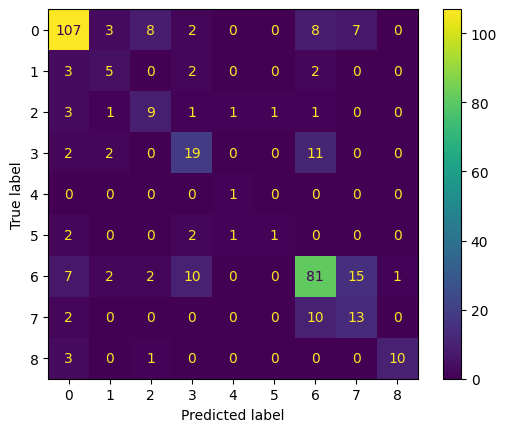

In [103]:
X_resampled, y_resampled = balance_classes(X_train, y_train, k_neighbors=2)

clf = train_model(X_resampled, y_resampled)
y_pred = make_prediction(clf, X_test)
acc = evaluate_model(y_test, y_pred)

Sampling strategy: minority
Min acc: 51.09%
Max acc: 54.05%
Avg acc: 52.33%
Sampling strategy: not minority
Min acc: 45.64%
Max acc: 48.66%
Avg acc: 46.94%
Sampling strategy: not majority
Min acc: 45.85%
Max acc: 59.83%
Avg acc: 56.11%
Sampling strategy: all
Min acc: 45.85%
Max acc: 59.83%
Avg acc: 56.11%


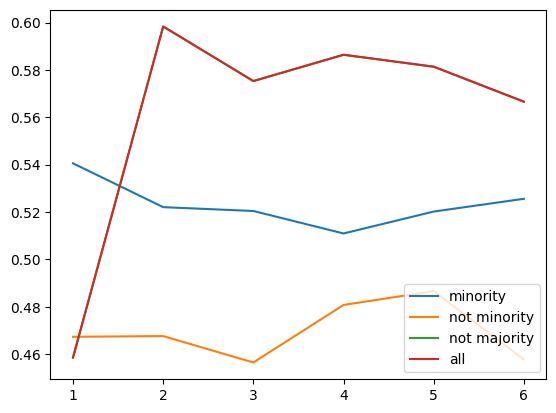

In [100]:
n_iterations = 10


sampling_strategy = ['minority', 'not minority', 'not majority', 'all']
k_neighbors = np.arange(1, 7, 1)

for s in sampling_strategy:
    
    acc_scores = []
    for k in k_neighbors:
        X_resampled, y_resampled = balance_classes(X_train, y_train, info = False, sampling_strategy=s, k_neighbors=k)

        clf = train_model(X_resampled, y_resampled)
        y_pred = make_prediction(clf, X_test)
        acc = evaluate_model(y_test, y_pred, print_acc = False, show_cm = False)

        acc_scores.append(acc)

    print(f'\nSampling strategy: {s}')
    print(f'Min acc: {min(acc_scores):.2%}')
    print(f'Max acc: {max(acc_scores):.2%}')
    print(f'Avg acc: {sum(acc_scores)/k_neighbors.size:.2%}')

    plt.plot(k_neighbors, acc_scores, label = s)

plt.legend()
plt.show() 
    

### Case 03: feature engineering + model

(1447, 167)
(1447, 114)
Balanced accuracy: 44.41%


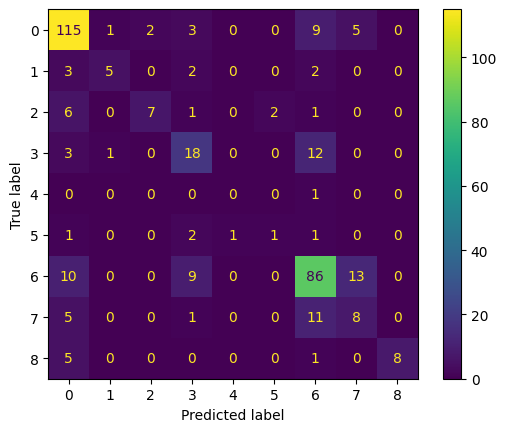

In [83]:
X_selected = select_features(pd.DataFrame(X_train), threshold = 0.07)
column_names = X_selected.columns
X_selected_test = X_test[column_names]

clf = train_model(X_selected, y_train)
y_pred = make_prediction(clf, X_selected_test)
acc = evaluate_model(y_test, y_pred)

Min acc: 39.51%
Max acc: 44.41%
Avg acc: 41.45%


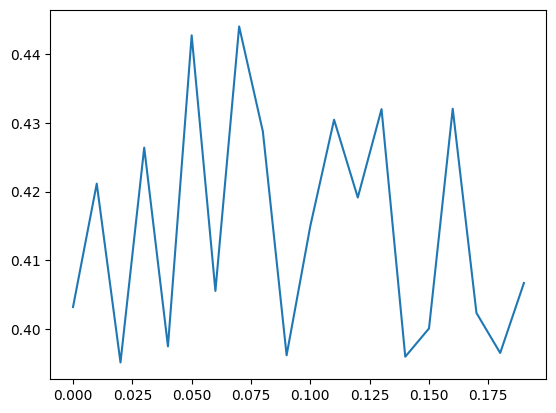

In [82]:
acc_scores = []
thresholds = np.arange(0, 0.2, 0.01)

for t in thresholds:
    X_selected = select_features(pd.DataFrame(X_train), threshold = t, info = False)
    column_names = X_selected.columns
    X_selected_test = X_test[column_names]

    clf = train_model(X_selected, y_train)
    y_pred = make_prediction(clf, X_selected_test)
    acc = evaluate_model(y_test, y_pred, print_acc = False, show_cm = False)

    acc_scores.append(acc)

print(f'Min acc: {min(acc_scores):.2%}')
print(f'Max acc: {max(acc_scores):.2%}')
print(f'Avg acc: {sum(acc_scores)/thresholds.size:.2%}')

plt.plot(thresholds, acc_scores)
plt.show() 

### Case 04: balancing data + feature engineering + model

Classes distribution before sampling : [(0, 596), (1, 38), (2, 52), (3, 115), (4, 7), (5, 19), (6, 471), (7, 100), (8, 49)]
Classes distribution after sampling: [(0, 596), (1, 596), (2, 596), (3, 596), (4, 596), (5, 596), (6, 596), (7, 596), (8, 596)]
(5364, 167)
(5364, 114)
Balanced accuracy: 59.86%


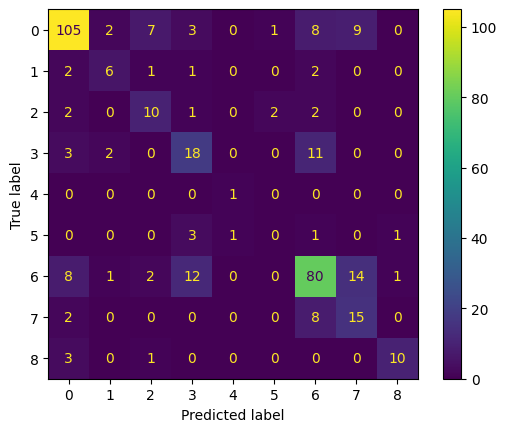

In [106]:
X_resampled, y_resampled = balance_classes(X_train, y_train, k_neighbors=4)

X_selected = select_features(pd.DataFrame(X_resampled), threshold = 0.05)
column_names = X_selected.columns
X_selected_test = X_test[column_names]

clf_04 = train_model(X_selected, y_resampled)
y_pred = make_prediction(clf, X_selected_test)
acc = evaluate_model(y_test, y_pred)


Threshold: 0.0
Min acc: 46.43%
Max acc: 58.74%
Avg acc: 55.79%

Threshold: 0.01
Min acc: 45.07%
Max acc: 58.01%
Avg acc: 53.52%

Threshold: 0.02
Min acc: 46.89%
Max acc: 59.44%
Avg acc: 56.07%

Threshold: 0.03
Min acc: 48.76%
Max acc: 58.96%
Avg acc: 56.02%

Threshold: 0.04
Min acc: 44.39%
Max acc: 59.17%
Avg acc: 55.64%

Threshold: 0.05
Min acc: 46.94%
Max acc: 59.86%
Avg acc: 56.27%

Threshold: 0.06
Min acc: 45.93%
Max acc: 58.32%
Avg acc: 55.71%

Threshold: 0.07
Min acc: 47.65%
Max acc: 59.02%
Avg acc: 55.61%

Threshold: 0.08
Min acc: 48.03%
Max acc: 58.97%
Avg acc: 56.21%

Threshold: 0.09
Min acc: 44.91%
Max acc: 57.38%
Avg acc: 53.55%

Threshold: 0.1
Min acc: 45.57%
Max acc: 56.64%
Avg acc: 51.12%

Threshold: 0.11
Min acc: 45.04%
Max acc: 57.01%
Avg acc: 51.03%

Threshold: 0.12
Min acc: 43.95%
Max acc: 46.81%
Avg acc: 45.33%

Threshold: 0.13
Min acc: 44.78%
Max acc: 55.70%
Avg acc: 47.88%

Threshold: 0.14
Min acc: 43.54%
Max acc: 56.71%
Avg acc: 51.06%

Threshold: 0.15
Min acc: 4

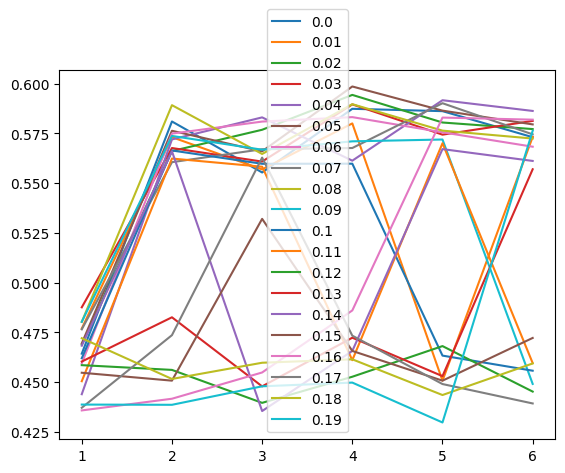

In [102]:
n_iterations = 10
acc_scores = []

sampling_strategy = ['minority', 'not minority', 'not majority', 'all']
k_neighbors = np.arange(1, 7, 1)
thresholds = np.arange(0, 0.2, 0.01)

for t in thresholds:
    acc_scores = []
    for k in k_neighbors:
        X_resampled, y_resampled = balance_classes(X_train, y_train, info = False, sampling_strategy='not majority', k_neighbors=k)

        X_selected = select_features(pd.DataFrame(X_resampled), threshold = t, info = False)
        column_names = X_selected.columns
        X_selected_test = X_test[column_names]

        clf = train_model(X_selected, y_resampled)
        y_pred = make_prediction(clf, X_selected_test)
        acc = evaluate_model(y_test, y_pred, print_acc = False, show_cm = False)

        acc_scores.append(acc)

    print(f'\nThreshold: {t}')
    print(f'Min acc: {min(acc_scores):.2%}')
    print(f'Max acc: {max(acc_scores):.2%}')
    print(f'Avg acc: {sum(acc_scores)/k_neighbors.size:.2%}')

    plt.plot(k_neighbors, acc_scores, label = t)

plt.legend()
plt.show() 

## Pipeline draft

Classes distribution : [(0, 731), (1, 50), (2, 69), (3, 149), (4, 8), (5, 25), (6, 589), (7, 125), (8, 63)]
Classes distribution : [(0, 731), (1, 731), (2, 731), (3, 731), (4, 731), (5, 731), (6, 731), (7, 731), (8, 731)]
(6579, 167)
(6579, 114)
Classes distribution train: [(0, 598), (1, 582), (2, 586), (3, 560), (4, 577), (5, 591), (6, 604), (7, 583), (8, 582)]
Classes distribution test: [(0, 133), (1, 149), (2, 145), (3, 171), (4, 154), (5, 140), (6, 127), (7, 148), (8, 149)]
Balanced accuracy: 89.39%


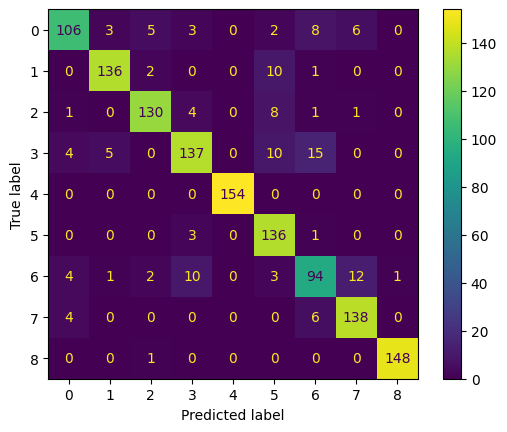

In [57]:
# 1) Zmień encoding
# ecfp_fp = ECFPFingerprint() #zmień rozmiar fingerprinta MACCS
# X = ecfp_fp.transform(df.smiles)
# y = df.taste
X = get_maccs_fps(df)
y = df.taste

# 2) Zbalansuj klasy
X_resampled, y_resampled = balance_classes(X, y)

# 3) Wyselekcjonuj atrybuty
X_selected = select_features(pd.DataFrame(X_resampled), threshold = 0.05)
column_names = X_selected.columns

# 4) Train test split
X_train, X_test, y_train, y_test  = train_test_split_data(X_selected, y_resampled)

# 5) Train model
clf = train_model(X_train, y_train)
y_pred = make_prediction(clf, X_test)
acc = evaluate_model(y_test, y_pred)

## Making predictions

In [36]:
df = pd.read_csv('data/test.csv')
df.head()

,molecule_id,smiles
0,test_0,NC(=O)NN=Cc1ccc([N+](=O)[O-])o1
1,test_1,CCOC=O
2,test_2,CCOC(=O)C(Cc1c[nH]c2ccccc12)NC(=O)C1CCCN1C(=O)...
3,test_3,CC1=CCC(C(C)(C)OC(=O)c2ccccc2N)CC1
4,test_4,O=S(=O)([O-])Nc1nnc(-c2ccccc2Br)s1.[Na+]


In [107]:
# 1) Zmień encoding
# ecfp_fp = ECFPFingerprint() #zmień rozmiar fingerprinta MACCS
# X = ecfp_fp.transform(df.smiles)
# y = df.taste
maccs = [MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x)) for x in df['smiles']]
maccs_lists = [list(l) for l in maccs]
maccs_name = [f'MACCS_{i}' for i in range(167)]
X = pd.DataFrame(maccs_lists, index=df.index, columns=maccs_name)

# 3) Wyselekcjonuj atrybuty
X = X[column_names]

# 4) Predict
model_predictions = clf_04.predict(X)

# 5) Save results


In [108]:
import csv
csv_file_path = f'./results/results_model_4_05.csv'

with open(csv_file_path, mode='w', newline='') as file:
    
    writer = csv.writer(file)
    file.write('molecule_id' + ',' + 'taste' + '\n')
    
    for i, pred in enumerate(model_predictions):
        file.write('test_' + str(i) + ',' + str(pred) + '\n')

print(f"CSV file '{csv_file_path}' created successfully!!!")

CSV file './results/results_model_4_05.csv' created successfully!!!
